In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import files
file_uploaded = files.upload()

Saving SBUX.csv to SBUX.csv


In [15]:
data=pd.read_csv('SBUX.csv')

In [17]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [18]:
data['Volume'] = data['Volume'].astype(float)

In [20]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

In [24]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

#여기까지는 LSTM 계층 코드와 같다.

In [25]:
#양방향 LSTM 모델 네트워크
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc =  nn.Linear(hidden_size*2, num_classes)
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

In [26]:
#모델 학습
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()

    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.09608
Epoch: 100, loss: 0.08047
Epoch: 200, loss: 0.06776
Epoch: 300, loss: 0.05749
Epoch: 400, loss: 0.04924
Epoch: 500, loss: 0.04264
Epoch: 600, loss: 0.03741
Epoch: 700, loss: 0.03327
Epoch: 800, loss: 0.03001
Epoch: 900, loss: 0.02748


In [28]:
#모델 평가
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

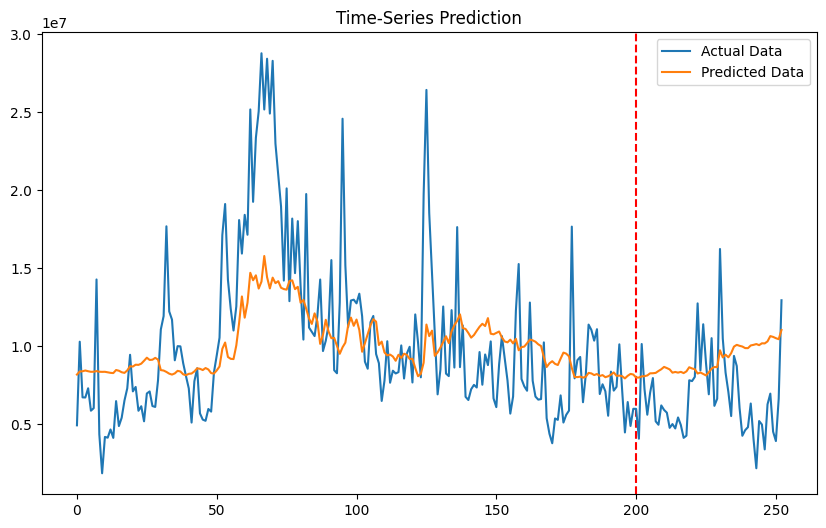

In [29]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()